In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tensorflow.examples.tutorials.mnist import input_data

from edward.models import Normal, Bernoulli, Empirical
import edward as ed

In [2]:
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)
mb_size = 64
z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128
c = 0
lr = 1e-3

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [4]:
# =============================== Q(z|X) Encoder ======================================

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, reuse=True):
    with tf.variable_scope('encoder', reuse=reuse):
        h = tf.nn.relu(tf.matmul(X, Q_W1) + Q_b1)
        z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
        z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
        return z_mu, z_logvar

# =============================== Sampling Helper ======================================
def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

# =============================== P(X|z) Decoder ======================================

P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z, reuse=True):
    with tf.variable_scope('decoder', reuse=reuse):
        h = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
        logits = tf.matmul(h, P_W2) + P_b2
        prob = tf.nn.sigmoid(logits)
        return prob, logits



In [5]:
# =============================== DEFINE LOSS ====================================
X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample)

# Sampling from random z
X_samples, _ = P(z)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
# D_KL(Q(z|X) || P(z)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer().minimize(vae_loss)

# sess = tf.Session()
sess = ed.get_session() # need to make sure tf and edward share the global session
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

In [6]:
# =============================== TRAINING ====================================
i = 0
max_iter = 20000

for it in range(max_iter):
    X_mb, _ = mnist.train.next_batch(mb_size)

    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()

        samples = sess.run(X_samples, feed_dict={z: np.random.randn(16, z_dim)})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

Iter: 0
Loss: 755.5
()
Iter: 1000
Loss: 144.5
()
Iter: 2000
Loss: 127.0
()
Iter: 3000
Loss: 119.7
()
Iter: 4000
Loss: 120.4
()
Iter: 5000
Loss: 113.3
()
Iter: 6000
Loss: 118.1
()
Iter: 7000
Loss: 115.7
()
Iter: 8000
Loss: 112.6
()
Iter: 9000
Loss: 112.5
()
Iter: 10000
Loss: 111.6
()
Iter: 11000
Loss: 112.1
()
Iter: 12000
Loss: 111.6
()
Iter: 13000
Loss: 105.8
()
Iter: 14000
Loss: 108.8
()
Iter: 15000
Loss: 113.8
()
Iter: 16000
Loss: 113.8
()
Iter: 17000
Loss: 109.6
()
Iter: 18000
Loss: 106.9
()
Iter: 19000
Loss: 105.7
()


## Check that VAE can Reconstruct GT

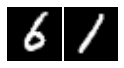

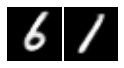

In [80]:
plt.close('all')
%matplotlib inline

num_checks = 2
x_gt, _ = mnist.train.next_batch(num_checks)
plot(x_gt)
plot(P(Q(x_gt)[0])[0].eval())
_ = 1 # prevent repeated plot in jupyter

In [7]:
def init_uninited_vars():
    unint_vars = []
    for var in tf.global_variables():
        if not tf.is_variable_initialized(var).eval():
            unint_vars.append(var)
    missingVarInit = tf.variables_initializer (unint_vars)
    sess.run(missingVarInit)

## HMC Inference

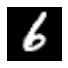

In [8]:
%matplotlib inline

inference_batch_size = 1
x_gt, _ = mnist.train.next_batch(inference_batch_size)
plot(x_gt)

T = 20000 # number of empirical samples in posterior
img_dim = 28
hmc_steps = T
leap_steps = 10
# print x_gt
# z = Normal(loc=tf.zeros([inference_batch_size, z_dim]), scale=tf.ones([inference_batch_size, z_dim])) # sample z
z = Normal(loc=Q(x_gt)[0], scale=tf.ones([inference_batch_size, z_dim])) # sample z

normalized_dec_x, dec_x_logits = P(z)
# print dec_x_logits.shape

X = Normal(loc=normalized_dec_x, scale=tf.ones([1, 28*28]))
  
# X = Normal(loc=dec_x, scale=tf.ones(img_dim)*sig) # likelihood distrib
qz = Empirical(params=tf.Variable(tf.zeros([T, inference_batch_size, z_dim])))

inference = ed.HMC({z: qz}, data={X: x_gt})

# inference.initialize(step_size=0.05, n_steps=leap_steps)
inference.initialize()
init_uninited_vars()

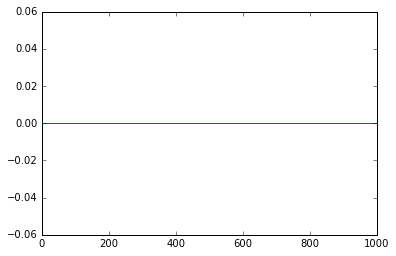

In [153]:
plt.plot(tf.squeeze(qz.params, 1).eval());

In [9]:
for i in range(hmc_steps):
    info_dict = inference.update()
    inference.print_progress(info_dict)

# inference.finalize()
# inference.run(variables=[], n_steps=hmc_steps)

20000/20000 [100%] ██████████████████████████████ Elapsed: 38s | Acceptance Rate: 0.878


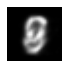

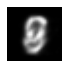

In [144]:
all_zeros = tf.Variable(tf.zeros([1, z_dim]))
sess.run(tf.variables_initializer([all_zeros]))
zeros_img, _ = P(all_zeros)
plot(zeros_img.eval())

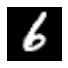

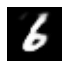

In [12]:
# inference.update()
keep_ratio = 0.2
to_keep_index = int((1-keep_ratio)*T)
qz_kept = Empirical(qz.params[to_keep_index:])

for element in range(inference_batch_size):
    z_test = qz_kept.sample(1)[:,element]
    img, _ = P(z_test)
    plot([x_gt[element]])
    plot(img.eval())

## Sample from Posterior and Reconstruct Image

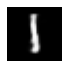

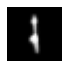

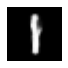

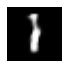

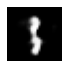

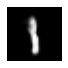

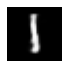

In [158]:
sample_to_vis = 5
qz_sample = qz_kept.sample(sample_to_vis)

for i in range(sample_to_vis):
    img, _ = P(qz_sample[i])
    plot(img.eval())
    
avg_img, _ = P(tf.reduce_mean(qz_sample, 0))
plot(avg_img.eval())

In [13]:
def recon_loss(x_gt,z_hmc): 
    return tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=P(z_hmc)[1], labels=x_gt), 1).eval()

In [14]:
num_to_best = 100

print recon_loss(x_gt,Q(x_gt)[0])

samples_to_check = qz_kept.sample(num_to_best).eval()

best_sample = samples_to_check[0]

for sample in samples_to_check:
    
#     print recon_loss(x_gt,this_sample)
    if recon_loss(x_gt,sample)<recon_loss(x_gt,best_sample):
        best_sample = sample
        print 'yay'
    print recon_loss(x_gt,sample)

[ 60.07982254]
[ 91.81243896]
yay
[ 85.92230988]
[ 92.70771027]
[ 106.04373932]
yay
[ 73.79493713]
[ 100.49784851]
[ 90.50302124]
[ 90.37689972]
[ 86.94503784]
[ 94.46937561]
[ 120.23963928]
[ 93.76238251]
[ 112.55857086]
[ 114.88426208]
[ 101.45747375]
[ 83.13262939]
[ 97.95941162]
[ 83.4263382]
[ 77.29904175]
[ 111.74755096]
[ 78.13861847]
[ 91.50671387]
yay
[ 69.85454559]
[ 85.09741974]
yay
[ 68.70373535]
[ 92.11201477]
[ 102.56273651]
[ 127.38512421]
[ 89.12137604]
[ 76.401474]
[ 81.28222656]
[ 75.48765564]
[ 81.77897644]
[ 89.84474945]
[ 75.05583191]
[ 96.02957153]
[ 87.59337616]
[ 87.87272644]
[ 116.18704987]
[ 97.48486328]
[ 100.67222595]
[ 75.92689514]
[ 104.40603638]
[ 79.69389343]
[ 76.99917603]
[ 112.27947998]
[ 92.74551392]
[ 125.26794434]
[ 110.28308105]
[ 94.46842957]
[ 70.79147339]
yay
[ 64.78424835]
[ 159.640625]
[ 87.59337616]
[ 84.32168579]
[ 109.90113068]
[ 80.04627991]
[ 90.04273224]
[ 83.16946411]
[ 140.27445984]
[ 89.08447266]
[ 114.38680267]
[ 89.65478516]
[ 94.1

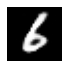

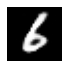

In [29]:
plot(P(best_sample)[0].eval())


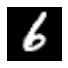

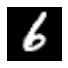

In [30]:
plot(x_gt)


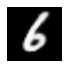

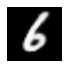

In [31]:

plot(P(Q(x_gt)[0])[0].eval())

In [203]:
best_sample.eval()

array([[-0.95212424, -0.06328762,  1.15245926, -1.89842546,  0.55811429,
         0.28280312,  1.36288333, -0.28184998,  0.9417032 ,  0.90358549,
         0.26905739,  0.08368081, -0.13203382, -0.92147446,  0.29938996,
         1.16178298, -0.01221067, -1.98057282,  0.38699692,  1.04599583,
         0.58394665, -0.99725592, -0.00950748, -0.27716935, -1.20402026,
         1.3431704 ,  1.10342491,  0.26597792,  0.59657621,  0.07928611,
         1.34685087, -0.62939471,  0.01714846,  1.36101007, -1.02673328,
        -0.79244512, -1.47798836, -0.52183121,  0.3043693 , -0.14730322,
         0.72478098, -0.76513886,  1.24852192, -0.74000216,  1.18806839,
         0.90432167,  1.0154866 , -1.30663764,  0.86737531,  0.79493713,
        -0.13313723, -0.70984679, -0.83949274,  0.4837237 ,  0.27060384,
         0.16487481, -1.33788598, -0.69531536,  0.00543284,  1.02623618,
        -1.54417562, -1.13814795,  1.41500294, -0.61554807,  0.60116261,
        -0.5156759 , -0.71881491,  1.18957877,  0.7

In [218]:
stored = qz_kept.sample(4)[:].eval()

In [224]:
stored

array([[[ -1.77094197e+00,   2.77774215e-01,  -1.15036726e+00,
           5.25301456e-01,   9.55294371e-01,   6.69355035e-01,
          -1.72050345e+00,   3.35078716e-01,  -5.86141586e-01,
          -4.74250972e-01,   2.66247940e+00,  -2.17966616e-01,
           5.29391527e-01,  -1.07459414e+00,   1.95989633e+00,
           9.54027951e-01,  -3.52927297e-01,   1.47278917e+00,
          -5.28152466e-01,  -8.81084085e-01,  -1.29410434e+00,
          -1.80810690e-03,  -6.20344996e-01,   9.65987802e-01,
          -5.01084089e-01,   4.87332255e-01,   1.49300170e+00,
          -9.29297328e-01,   1.97481692e+00,  -1.22652836e-01,
          -1.05771375e+00,   1.88145280e-01,  -8.50787222e-01,
           2.00365663e-01,  -6.21669054e-01,  -1.32686973e-01,
          -5.69190502e-01,   1.46621060e+00,   1.70628381e+00,
          -9.07984734e-01,  -6.88962579e-01,   1.26945972e+00,
          -1.44501138e+00,  -1.36460459e+00,   1.32471228e+00,
          -6.16100848e-01,  -1.68069744e+00,  -1.003656